Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [49]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [50]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>84)
GROUP BY ID
order by potential DESC;
"""



In [51]:
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()

,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Position,Unnamed: 0,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,€0,2121.0,"RW,RF,ST,CAM",11360.0,85.0,91.0,69.0,89.0,88.0,97.0,87.0,82.0,75.0,96.0,94.0,88.0,96.0,89.0,86.0,79.0,64.0,75.0,59.0,87.0,48.0,22.0,90.0,91.0,86.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,NaN,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,€0,2223.0,"RW,CAM,LW,ST",11359.0,84.0,89.0,87.0,81.0,85.0,93.0,88.0,88.0,71.0,95.0,93.0,94.0,94.0,88.0,84.0,93.0,91.0,85.0,80.0,91.0,61.0,24.0,88.0,80.0,82.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,€105K,1911.0,"RW,LW,CAM",12092.0,69.0,73.0,66.0,71.0,66.0,85.0,84.0,56.0,67.0,83.0,81.0,78.0,83.0,79.0,67.0,74.0,63.0,77.0,71.0,74.0,53.0,32.0,74.0,75.0,67.0,NaN,34.0,32.0,5.0,9.0,6.0,15.0,7.0,84.0,35.0,91.0,20.0,78.0,RW,0,1,1.0,35.0
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,€0,1958.0,"RW,LW,CF,RM",11226.0,74.0,76.0,64.0,80.0,67.0,84.0,68.0,64.0,68.0,86.0,87.0,86.0,83.0,78.0,76.0,72.0,67.0,74.0,56.0,74.0,54.0,42.0,80.0,82.0,75.0,35.0,32.0,29.0,11.0,12.0,6.0,8.0,8.0,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,€90K,1929.0,"RW,LW",12571.0,72.0,78.0,62.0,73.0,67.0,84.0,80.0,73.0,57.0,80.0,88.0,86.0,87.0,78.0,85.0,71.0,73.0,81.0,45.0,71.0,54.0,21.0,83.0,71.0,74.0,NaN,36.0,32.0,9.0,8.0,12.0,8.0,5.0,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0


In [52]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'test', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Overall<83)&(df.Age<26)&(df.Potential>83)]

In [53]:

df = df[df.prime_age>df.potential_age]
df['target'] = df.PrimeOverall>82
df = df[df.potential_age<26]
df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()
df_processed.head()

target
False    149
True      89
Name: count, dtype: int64


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Position,Unnamed: 0,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense,set,target
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,€0,2121.0,"RW,RF,ST,CAM",11360.0,85.0,91.0,69.0,89.0,88.0,97.0,87.0,82.0,75.0,96.0,94.0,88.0,96.0,89.0,86.0,79.0,64.0,75.0,59.0,87.0,48.0,22.0,90.0,91.0,86.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,NaN,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0,drop,True
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,€0,2223.0,"RW,CAM,LW,ST",11359.0,84.0,89.0,87.0,81.0,85.0,93.0,88.0,88.0,71.0,95.0,93.0,94.0,94.0,88.0,84.0,93.0,91.0,85.0,80.0,91.0,61.0,24.0,88.0,80.0,82.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0,drop,True
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,€0,1958.0,"RW,LW,CF,RM",11226.0,74.0,76.0,64.0,80.0,67.0,84.0,68.0,64.0,68.0,86.0,87.0,86.0,83.0,78.0,76.0,72.0,67.0,74.0,56.0,74.0,54.0,42.0,80.0,82.0,75.0,35.0,32.0,29.0,11.0,12.0,6.0,8.0,8.0,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0,drop,True
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,€90K,1929.0,"RW,LW",12571.0,72.0,78.0,62.0,73.0,67.0,84.0,80.0,73.0,57.0,80.0,88.0,86.0,87.0,78.0,85.0,71.0,73.0,81.0,45.0,71.0,54.0,21.0,83.0,71.0,74.0,NaN,36.0,32.0,9.0,8.0,12.0,8.0,5.0,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0,test,False
208790,Z. Bakkali,2014,17.0,17.0,https://cdn.sofifa.net/players/208/790/14_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,73.0,90.0,PSV,https://cdn.sofifa.net/meta/team/682/30.png,€2.1M,€30K,1734.0,"RW,LW",9423.0,64.0,64.0,27.0,62.0,69.0,86.0,74.0,67.0,52.0,78.0,87.0,83.0,87.0,66.0,92.0,69.0,68.0,57.0,30.0,72.0,36.0,25.0,65.0,67.0,56.0,25.0,25.0,25.0,10.0,5.0,15.0,11.0,15.0,NaN,NaN,90.0,20.0,74.0,RW,0,1,1.0,25.0,train,False


In [54]:
df_processed.best_position.value_counts()

best_position
ST    111
RW     50
LW     50
CF     21
RF      4
LF      2
Name: count, dtype: int64

In [55]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,24.0,95.0,95.0,90.0,94.0,True,drop,RW
20801,Cristiano Ronaldo,2011,25.0,25.0,31.0,94.0,94.0,89.0,94.0,True,drop,RW
183277,E. Hazard,2011,19.0,19.0,27.0,91.0,91.0,81.0,91.0,True,drop,RW
243812,Rodrygo,2021,19.0,19.0,21.0,90.0,90.0,79.0,81.0,False,test,RW
208790,Z. Bakkali,2014,17.0,17.0,20.0,90.0,90.0,73.0,74.0,False,train,RW


In [56]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

## Deskriptive Analyse

In [57]:
df.select_dtypes(exclude='object').corr()['target'].round(2).sort_values().head(100)

Defense               -0.10
Marking               -0.01
central               -0.01
StandingTackle        -0.01
SlidingTackle         -0.01
GKPositioning         -0.00
GKReflexes            -0.00
winger                 0.01
GKDiving               0.05
GKKicking              0.07
Jumping                0.08
Defensive awareness    0.08
GKHandling             0.08
Agility                0.10
HeadingAccuracy        0.15
Balance                0.15
SprintSpeed            0.17
Acceleration           0.18
Strength               0.18
Interceptions          0.18
Unnamed: 0             0.20
Aggression             0.24
LongPassing            0.26
Composure              0.27
FKAccuracy             0.28
max_potential          0.28
Potential              0.28
Crossing               0.29
Stamina                0.31
Penalties              0.36
ShotPower              0.37
Dribbling              0.37
potential_age          0.39
Curve                  0.39
ShortPassing           0.39
Age                 

In [58]:
df[df.target].describe().round(3)
pd.set_option('display.max_columns', 3000)
df[df.target].describe().round(3).compare(df[~df.target].describe().round(3))



potential_age              Age          Overall          Potential  \
               self    other    self    other    self    other      self   
count        89.000  149.000  89.000  149.000  89.000  149.000    89.000   
mean         21.663   19.685  21.663   19.685  79.067   72.597    86.775   
std           2.369    2.156   2.369    2.156   4.835    5.088     1.929   
min          17.000   16.000  17.000   16.000  63.000   59.000       NaN   
25%          20.000   18.000  20.000   18.000  76.000   68.000       NaN   
50%          22.000   19.000  22.000   19.000  80.000   74.000    86.000   
75%          23.000   21.000  23.000   21.000  82.000   76.000    87.000   
max             NaN      NaN     NaN      NaN  90.000   81.000    95.000   

                 Special           Unnamed: 0            Crossing           \
         other      self     other       self      other     self    other   
count  149.000    89.000   149.000     89.000    149.000   89.000  149.000   
mean    85.846  1922.191  1774.443  11282.809  10243.812   67.944   60.289   
std      1.256   127.148   146.070   2068.835   2627.929   11.691   12.326   
min        NaN  1569.000  1424.000   5300.000   2018.000   34.000   28.000   
25%        NaN  1843.000  1673.000  10508.000   8563.000   63.000   52.000   
50%     85.000  1936.000  1788.000  11129.000  10391.000   70.000   63.000   
75%     86.000  1985.000  1878.000  11312.000  11875.000   75.000   69.000   
max     90.000  2316.000  2094.000  17353.000  17148.000   89.000   87.000   

      Finishing          HeadingAccuracy          ShortPassing           \
           self    other            self    other         self    other   
count    89.000  149.000          89.000  149.000       89.000  149.000   
mean     78.157   70.550          63.820   59.872       73.753   67.121   
std       7.628    7.608          14.312   12.161        6.881    8.023   
min      59.000   50.000          29.000   17.000       53.000   40.000   
25%      74.000   66.000          52.000   53.000       70.000   63.000   
50%      79.000   70.000          66.000   60.000       74.000   68.000   
75%      84.000   76.000          75.000   68.000       78.000   73.000   
max      92.000   87.000          92.000   84.000       89.000   83.000   

      Volleys          Dribbling            Curve          FKAccuracy  \
         self    other      self    other    self    other       self   
count  89.000  149.000    89.000  149.000  89.000  149.000     89.000   
mean   72.225   64.013    81.213   75.409  72.056   62.718     62.685   
std     9.066    9.136     7.014    7.091   9.142   11.417     14.188   
min    41.000   42.000    62.000   55.000  43.000   33.000     32.000   
25%    67.000   59.000    76.000   70.000  66.000   56.000     52.000   
50%    72.000   64.000    84.000   76.000  72.000   64.000     67.000   
75%    80.000   70.000    86.000   80.000  80.000   71.000     74.000   
max    91.000   84.000    97.000   89.000  88.000   82.000     88.000   

               LongPassing          BallControl          Acceleration  \
         other        self    other        self    other         self   
count  149.000      89.000  149.000      89.000  149.000       89.000   
mean    54.758      61.876   56.034      81.270   74.604       83.618   
std     12.481      11.393   10.299       5.969    6.347        6.406   
min     29.000      33.000   31.000      64.000   51.000       69.000   
25%     45.000      53.000   48.000      78.000   71.000       79.000   
50%     54.000      63.000   57.000      82.000   75.000       85.000   
75%     65.000      69.000   64.000      85.000   80.000       88.000   
max     86.000      87.000   78.000      96.000   86.000          NaN   

               SprintSpeed          Agility          Reactions           \
         other        self    other    self    other      self    other   
count  149.000      89.000  149.000  89.000  149.000    89.000  149.000   
mean    81.067      82.831

###  Feature Engineering

In [59]:
PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = [ 'overall_age_ratio','Crossing', 'Finishing',  'ShortPassing',  'Dribbling', 'Curve',  'LongPassing', 'BallControl',
                      'Agility',  'Composure',  'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'Aggression',  'Positioning', 'Vision', 'Penalties']
# PLAYER_ATTRIBUTES = [ 'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance',  'Jumping', 'Stamina', 'Strength',  'Aggression', 'Positioning', 'Vision']

#### Transform Defense Attributs

#### Transform Value

In [60]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

In [61]:
df['target'].value_counts()

target
False    149
True      89
Name: count, dtype: int64

In [62]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [63]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [64]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

In [73]:
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
import xgboost as xgb
import lightgbm as lgb
import warnings
import shap 
import shap  # For SHAP values
import pickle

# Define class weights (if applicable)
class_weights = 'balanced'  # You can customize these weights if needed

# Create and train different classification models with class weights
models = {
    'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'Decision Tree Classifier': DecisionTreeClassifier(class_weight=class_weights),
    'Random Forest Classifier': RandomForestClassifier(class_weight=class_weights, **{'n_estimators': 230, 'max_depth': 19, 'min_samples_split': 0.13490874502369332, 'min_samples_leaf': 0.12691574778299552}),
    'Support Vector Classifier': SVC(class_weight=class_weights,probability=True,kernel='linear'),
    'XGBoost Classifier': xgb.XGBClassifier(),
    'LightGBM Classifier': lgb.LGBMClassifier()
}

model_results = {}

for model_name, model in models.items():
    print(model_name,"training----->")
    model.fit(X_train_scaled_df, y_train)

    y_pred = model.predict(X_test_scaled_df)
    
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled_df)[:, 1]
    else:
        y_prob = None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None
    
    precision = precision_score(y_test, y_pred)
    
    model_results[model_name] = {
        'Model': model,
        'Scaler':scaler,
        'attributes':PLAYER_ATTRIBUTES,
        'Accuracy': accuracy,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix,
        'AUC': auc,
        'Precision': precision
    }
if True:
    try:
        # Save SHAP values to a pickle file
        with open(f"data/sport_analytics/model/{PREDICTION_NAME}_trained_models.pkl", "wb") as file:
            pickle.dump(model_results, file)
    except:
        print("Fehler save Models",model_name)

# Evaluate and print results for each model
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print("Classification Report:")
    print(results['Classification Report'])
    print("Confusion Matrix:")
    print(results['Confusion Matrix'])
    if results['AUC'] is not None:
        print(f"AUC: {results['AUC']:.2f}")
    if 'Precision' in results:
        print(f"Precision: {results['Precision']:.2f}")
    print()


Logistic Regression training----->
Decision Tree Classifier training----->
Random Forest Classifier training----->
Support Vector Classifier training----->
XGBoost Classifier training----->
LightGBM Classifier training----->
[LightGBM] [Info] Number of positive: 42, number of negative: 51
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 424
[LightGBM] [Info] Number of data points in the train set: 93, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451613 -> initscore=-0.194156
[LightGBM] [Info] Start training from score -0.194156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

### evaluate test data

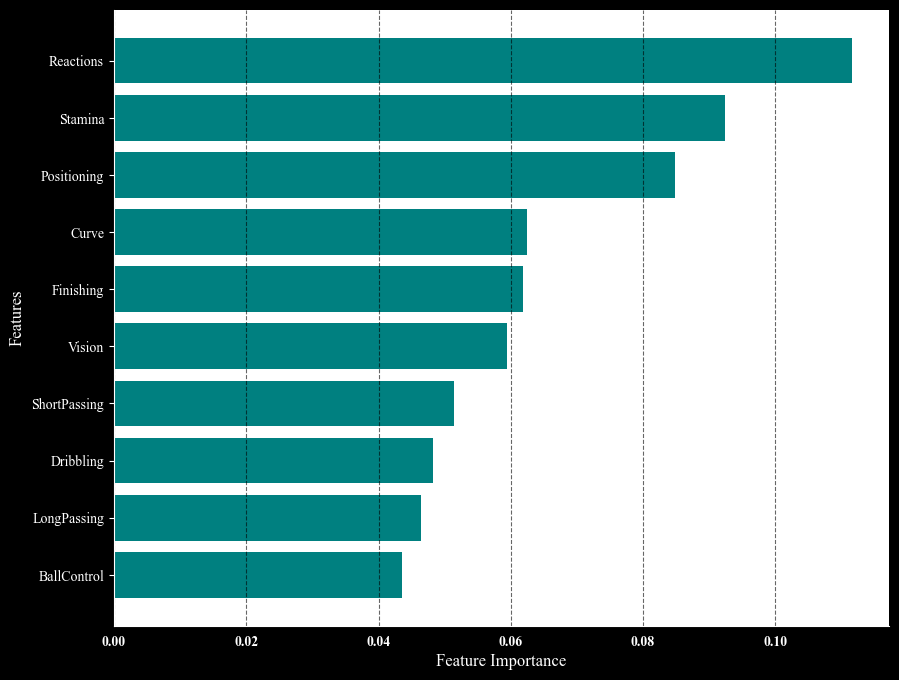

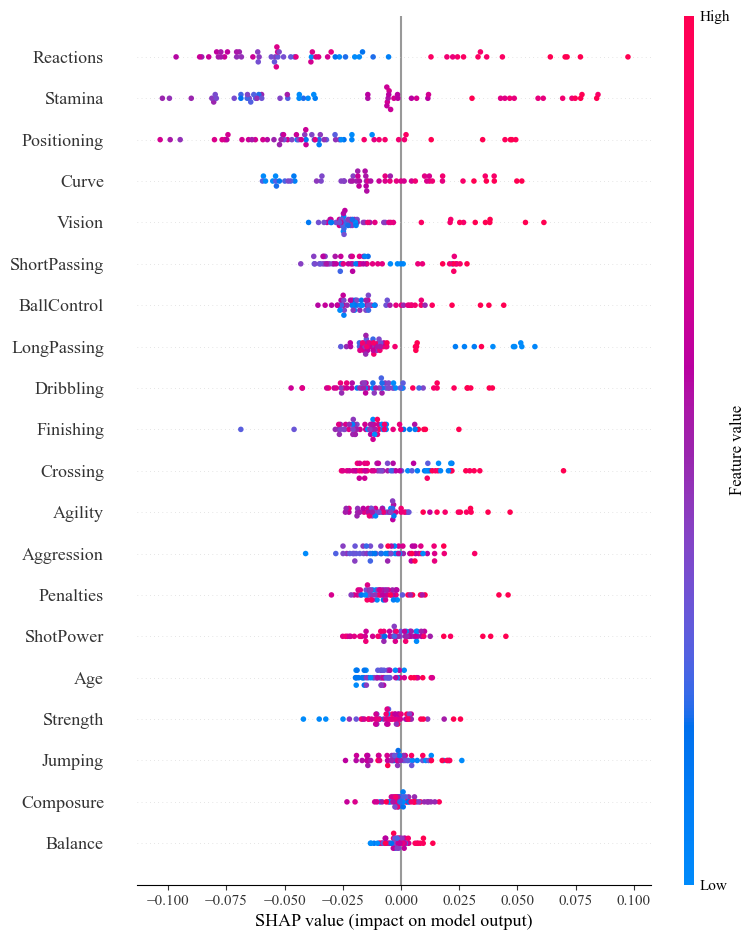

['Reactions',
 'Stamina',
 'Positioning',
 'Curve',
 'Finishing',
 'Vision',
 'ShortPassing',
 'Dribbling',
 'LongPassing',
 'BallControl']

In [66]:
my_model = model_results['Random Forest Classifier']['Model']


from src.sport_analytics.model.eval import individual_shap_valuess,plot_feature_importance

features = plot_feature_importance(my_model, '')
explainer = shap.Explainer(my_model)
shap_values = explainer.shap_values(X_test_scaled_df)
shap.summary_plot(shap_values[1], X_test_scaled_df)

features

In [67]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    
    # Create and train the Random Forest Classifier with suggested hyperparameters
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    clf.fit(X_train_scaled_df, y_train)
    
    # Make probability predictions on the validation set
    y_pred_prob = clf.predict_proba(X_test_scaled_df)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    
    return auc

# Create an Optuna study for maximizing AUC
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

best_params = study.best_params
best_auc = study.best_value

print("Best hyperparameters:", best_params)
print("Best AUC:", best_auc)


[I 2023-10-22 16:34:30,022] A new study created in memory with name: no-name-2829253f-6a23-4457-8bc9-4af5773e84e0


[I 2023-10-22 16:34:32,194] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 560, 'max_depth': 17, 'min_samples_split': 0.8068904966249982, 'min_samples_leaf': 0.3866684304668039}. Best is trial 0 with value: 0.5.
[I 2023-10-22 16:34:33,948] Trial 1 finished with value: 0.6911764705882353 and parameters: {'n_estimators': 875, 'max_depth': 30, 'min_samples_split': 0.3920531435392274, 'min_samples_leaf': 0.2605312641100658}. Best is trial 1 with value: 0.6911764705882353.
[I 2023-10-22 16:34:35,226] Trial 2 finished with value: 0.7034313725490196 and parameters: {'n_estimators': 639, 'max_depth': 12, 'min_samples_split': 0.6588395611106408, 'min_samples_leaf': 0.1298666558910625}. Best is trial 2 with value: 0.7034313725490196.
[I 2023-10-22 16:34:36,198] Trial 3 finished with value: 0.698529411764706 and parameters: {'n_estimators': 720, 'max_depth': 8, 'min_samples_split': 0.614145303839376, 'min_samples_leaf': 0.13997325894697255}. Best is trial 2 with value: 0.703431

Best hyperparameters: {'n_estimators': 230, 'max_depth': 19, 'min_samples_split': 0.13490874502369332, 'min_samples_leaf': 0.12691574778299552}
Best AUC: 0.7352941176470588


In [69]:
import plotly
optuna.visualization.plot_parallel_coordinate(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [ ]:
optuna.visualization.plot_optimization_history(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.